In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import nltk
dler = nltk.downloader.Downloader()
dler._update_index()
dler.download('all')

# File loading, Train-test-split

In [0]:
import pickle
import os
import pandas as pd
import numpy as np
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline

import time
seed = int(time.strftime("%Y%m%d"))

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/sol_classification.pickle'
data = pickle.load(open(path, "rb"))
data.comments = data.comments.apply('\n'.join)

In [0]:
# suppress categories with freq less than 2%
freq = data['category'].value_counts(normalize=True)
data['category'].replace(to_replace=list(freq[freq<0.02].index),value='others',inplace=True)
data['category'].value_counts(normalize=True)

games           0.268832
exchanges       0.216102
finance         0.156309
gambling        0.093691
others          0.056026
high-risk       0.044727
marketplaces    0.039077
social          0.036723
development     0.033427
media           0.031544
property        0.023540
Name: category, dtype: float64

In [0]:
# dummy coding for target variables
dummies = data['category'].str.get_dummies()
X = data.loc[:,('source_code','uncommented','comments')]
dummies.shape, X.shape

((2124, 11), (2124, 3))

In [0]:
# train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, dummies, test_size = 0.25, random_state = seed, stratify=data.category)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1593, 3), (531, 3), (1593, 11), (531, 11))

234.3019460138104

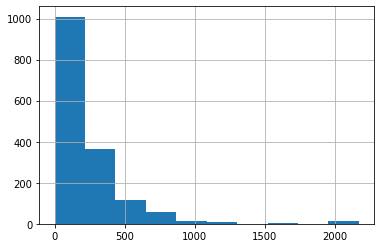

In [0]:
comment_len = X_train['comments'].apply(lambda x: len([line for line in x.split('\n') if line.strip() != '']))
comment_len.hist()
comment_len.mean()

# Feature Engineering

## Non-NLP features:
length of comments, length of codes and the comment/code ratio


In [0]:
def X_non_NLP_features (X):
  code_len = X['uncommented'].apply(lambda x: len([line for line in x.split('\n') if line.strip() != '']))
  X = X.assign(code_len = code_len)

  comment_len = X['comments'].apply(lambda x: len([line for line in x.split('\n') if line.strip() != '']))
  X = X.assign(comment_len = comment_len)

  comment_ratio = comment_len/code_len
  X = X.assign(comment_ratio = comment_ratio)

  X.drop(labels=['source_code','uncommented','comments'],axis=1,inplace=True)
  return np.array(X)

## NLP bag-of-word(BOW) tokenizer

In [0]:
# NLP imports
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
my_stopwords = stopwords.words("english")
my_stopwords.append("")

In [0]:
regex_tokenizer = nltk.RegexpTokenizer(r"[\w^@]+")
corpus = ' '.join(X_train[0:20]['comments'].values)
new_words = regex_tokenizer.tokenize(corpus)

new_words = sum([word.split('_') for word in new_words],[])
new_words = [re.sub('[0-9]','', word) for word in new_words]
new_words = [re.sub('([A-Z][a-z]+)',r' \1',re.sub('([A-Z]+)',r' \1', word)).split() for word in new_words]
new_words = sum(new_words, [])

fdist1 = nltk.FreqDist(new_words)
fdist1.most_common(100)

[('the', 1348),
 ('to', 792),
 ('of', 526),
 ('token', 489),
 ('@param', 406),
 ('@dev', 397),
 ('a', 338),
 ('address', 320),
 ('is', 307),
 ('owner', 219),
 ('contract', 217),
 ('be', 203),
 ('tokens', 192),
 ('amount', 189),
 ('in', 181),
 ('The', 174),
 ('that', 168),
 ('by', 165),
 ('if', 147),
 ('for', 145),
 ('ERC', 145),
 ('and', 143),
 ('from', 141),
 ('ID', 134),
 ('connector', 122),
 ('function', 121),
 ('this', 116),
 ('an', 114),
 ('transfer', 113),
 ('@return', 113),
 ('on', 107),
 ('new', 105),
 ('given', 96),
 ('not', 93),
 ('uint', 92),
 ('Token', 79),
 ('value', 72),
 ('it', 71),
 ('will', 68),
 ('can', 68),
 ('s', 67),
 ('only', 67),
 ('balance', 67),
 ('return', 67),
 ('which', 66),
 ('conversion', 66),
 ('when', 65),
 ('called', 65),
 ('sender', 62),
 ('bytes', 62),
 ('account', 61),
 ('or', 61),
 ('Id', 61),
 ('with', 60),
 ('contracts', 59),
 ('operator', 55),
 ('number', 51),
 ('Returns', 49),
 ('https', 48),
 ('call', 48),
 ('spender', 48),
 ('P', 48),
 ('@titl

In [0]:
def my_tokenizer (text):
  
  #tokenize
  regex_tokenizer = nltk.RegexpTokenizer(r"[\w^@]+")
  new_words = regex_tokenizer.tokenize(text)

  #remove numbers
  new_words = [re.sub('[0-9]','', word) for word in new_words]

  #split additionally by under_score
  new_words = sum([word.split('_') for word in new_words],[])

  #clear camelCase
  new_words = [re.sub('([A-Z][a-z]+)',r' \1',re.sub('([A-Z]+)',r' \1', word)).split() for word in new_words]
  new_words = sum(new_words, [])

  return new_words

In [0]:
vectorizer = TfidfVectorizer(stop_words = my_stopwords, tokenizer = my_tokenizer, lowercase = True,
                max_features =1000, smooth_idf=True, analyzer = 'word')

## Word-to-Vec

In [0]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
# define my W2V tokenizor
def build_corpus (list_of_text):

  corpus = []

  regex_tokenizer = nltk.RegexpTokenizer(r"[\w^@]+")
  my_stopwords = stopwords.words("english")
  my_stopwords.append("")

  for i in range(0,len(list_of_text)):
    text = list_of_text[i]
    text = regex_tokenizer.tokenize(text)
    text = sum([word.split('_') for word in text],[])
    text = [re.sub('[0-9]','', word) for word in text]
    text = [re.sub('([A-Z][a-z]+)',r' \1',re.sub('([A-Z]+)',r' \1', word)).split() for word in text]
    text = sum(text, [])

    text = [w for w in text if not w in my_stopwords]
    W2V_corpus.append(text)
  return corpus

In [0]:
# build corpus base on the train comments
W2V_train_corpus = build_corpus(X_train['comments'].values)
W2V_test_corpus = build_corpus(X_test['comments'].values)

In [0]:
# build dictionary on the train comments corpus
tokenizer_obj=Tokenizer(num_words=1000, lower=True)
tokenizer_obj.fit_on_texts(W2V_train_corpus)

# tokenize the train and the test set
W2V_seq=tokenizer_obj.texts_to_sequences(W2V_train_corpus)
W2V_test_seq=tokenizer_obj.texts_to_sequences(W2V_test_corpus)

In [0]:
# show the vocabulary size and stat for comments
word_index=tokenizer_obj.word_index
print('vocab size: ',len(word_index))

comment_len = np.array([len(comments) for comments in W2V_seq])
print('Max comment length: ',comment_len.max())
print('Mean comment length: ',int(comment_len.mean()))
print('SD of comment length: ',int(np.std(comment_len)))

vocab size:  11464
Max comment length:  7607
Mean comment length:  841
SD of comment length:  1099


In [0]:
# decide on the max length to cover
maxlen = 2000
W2V_train_seq=pad_sequences(W2V_seq,maxlen=maxlen)
W2V_test_seq=pad_sequences(W2V_test_seq,maxlen=maxlen)

In [0]:
W2V_train_seq.shape,W2V_test_seq.shape

((1593, 2000), (531, 2000))

### Alternative Pre-trained Embedding

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [0]:
# download the pre-trained weights
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-04-19 08:16:38--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.93.221
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.93.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  47.8MB/s    in 33s     

2020-04-19 08:17:12 (47.1 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
# store it in the W2V format
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
googlenews_w2v = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# initialize the W2V weight matrix
googlenews_w2v_matrix = np.zeros((len(word_index) + 1, 300))

In [0]:
# get the vocabulary
key = list(googlenews_w2v.vocab.keys())

In [0]:
# fill in the W2V weight matrix
for word,i in word_index.items():
  if word in key:
    googlenews_w2v_matrix[i] = googlenews_w2v.get_vector(word)

# Models based on BOW: logit, lightbm, multilayer perceptron

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/params_search.pickle'
DApps_model_params = pickle.load(open(path, "rb"))

In [0]:
# logit model
def logit_model (X_train,y_train,params):
  #logreg = LogisticRegression(penalty=params['penalty'],max_iter=1000)
  logreg = LogisticRegression(penalty=params['penalty'],C=params['C'],max_iter=10000)
  logreg.fit(X_train, y_train)
  return logreg

In [0]:
# lightbm model
def lightbm_model (X_train,y_train,params):

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed, stratify=y_train)

  train_data = lgb.Dataset(X_train,label=y_train)
  validation_data = lgb.Dataset(X_val,label=y_val)

  params.update([('objective','binary'),('metric','auc')])
  num_round = 100
  bst = lgb.train(params, train_data, num_round, valid_sets=validation_data,verbose_eval=False,early_stopping_rounds=5)

  return bst

In [0]:
def mlp_model (X_train,y_train,params):
  mlp_classifier = MLPClassifier(hidden_layer_sizes=params['hidden_layer_sizes'],solver=params['solver'],early_stopping=True,max_iter=10000)
  mlp_classifier.fit(X_train, y_train)
  return mlp_classifier

In [0]:
# cross_validation for opt params
DApps_model_params = {}
DApps_model_score = {}
for DApp_type in data['category'].value_counts().index:

  y_train = np.array(Y_train[DApp_type])
  X_train_xNLP = np.array(X_non_NLP_features(X_train))
  X_train_NLP = vectorizer.fit_transform(X_train['comments'])
  X_train_CV = hstack((X_train_xNLP,X_train_NLP)).toarray()

  scaler = MinMaxScaler()
  X_train_CV = scaler.fit_transform(X_train_CV)

  params_dist = {'logit':{'penalty':['l1','l2'],'C':[0.5,1,2]},
           'lightbm':{'num_leaves':[32, 64, 128]},
           'mlp':{'hidden_layer_sizes':[(64,32),(128,32),(256,32)],
               'solver':['adam'],
               'n_iter_no_change':[5]}}

  #print('Fitting logit')
  logit_classifier = LogisticRegression(max_iter=10000)
  logit_search = RandomizedSearchCV(logit_classifier, param_distributions=params_dist['logit'], n_iter=3, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
  logit_search.fit(X_train_CV,y_train)

  #print('Fitting lightbm')
  lgb_classifier = lgb.LGBMClassifier()
  #lgb_search = GridSearchCV(lgb_classifier, param_grid=params_dist['lightbm'], cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
  lgb_search = RandomizedSearchCV(lgb_classifier, param_distributions=params_dist['lightbm'], n_iter=3, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
  lgb_search.fit(X_train_CV,y_train)

  #print('Fitting MLP')
  mlp_classifier = MLPClassifier(early_stopping=True,max_iter=10000)
  #mlp_search = GridSearchCV(mlp_classifier, param_grid=params_dist['mlp'], cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
  mlp_search = RandomizedSearchCV(mlp_classifier, param_distributions=params_dist['mlp'], n_iter=3, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
  mlp_search.fit(X_train_CV,y_train)

  searches = {'logit_params':logit_search.best_params_,'lgb_params':lgb_search.best_params_,'mlp_params':mlp_search.best_params_}
  DApps_model_params.update([(DApp_type,searches)])
  scores = {'logit_score':logit_search.best_score_,'lgb_score':lgb_search.best_score_,'mlp_score':mlp_search.best_score_}
  DApps_model_score.update([(DApp_type,scores)])

with open('params_search.pickle', 'wb') as handle:
  pickle.dump(DApps_model_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
table_cv = []
for DApp_type in DApps_model_score:
  cv_aucs = [cv_score for cv_score in DApps_model_score[DApp_type].values()]
  cv_aucs.append(DApp_type)
  table_cv.append(cv_aucs)

table_cv
table_cv = pd.DataFrame(table_cv)
table_cv.columns = ['logit_cv','lightbm_cv','mlp_cv','category']
table_cv.set_index('category',inplace=True)
table_cv

,logit_cv,lightbm_cv,mlp_cv
category,,,
games,0.900635,0.912480,0.900090
exchanges,0.959379,0.955496,0.954687
finance,0.904681,0.908626,0.892875
gambling,0.888100,0.900053,0.885413
others,0.842408,0.839435,0.614871
high-risk,0.905709,0.896943,0.747480
marketplaces,0.774803,0.754351,0.580236
social,0.762166,0.722853,0.605930
development,0.820489,0.813542,0.605416


In [0]:
# main function

test_aucs = []
for DApp_type in data['category'].value_counts().index:
  y_train = np.array(Y_train[DApp_type])
  y_test = np.array(Y_test[DApp_type])

  X_train_xNLP = np.array(X_non_NLP_features(X_train))
  X_train_NLP = vectorizer.fit_transform(X_train['comments'])
  X_train_set = hstack((X_train_xNLP,X_train_NLP)).toarray()

  X_test_xNLP = np.array(X_non_NLP_features(X_test))
  X_test_NLP = vectorizer.transform(X_test['comments'])
  X_test_set = hstack((X_test_xNLP,X_test_NLP)).toarray()

  scaler = MinMaxScaler()
  X_train_set = scaler.fit_transform(X_train_set)
  X_test_set = scaler.transform(X_test_set)

  logit = logit_model(X_train_set,y_train,models_search[DApp_type]['logit_params'])
  lightbm = lightbm_model(X_train_set,y_train,models_search[DApp_type]['lgb_params'])
  mlp = mlp_model(X_train_set,y_train,models_search[DApp_type]['mlp_params'])

  test_aucs.append([DApp_type,roc_auc_score(y_test,logit.predict(X_test_set)),roc_auc_score(y_test,lightbm.predict(X_test_set)),roc_auc_score(y_test,[x[1] for x in mlp.predict_proba(X_test_set)])])

In [0]:
# output
table_test = pd.DataFrame(test_aucs)
table_test.columns = ['category','logit','lightbm','mlp']
table_test.set_index('category',inplace=True)
table_test

,logit,lightbm,mlp
category,,,
games,0.806944,0.919544,0.906730
exchanges,0.899540,0.937949,0.961716
finance,0.738059,0.892642,0.864202
gambling,0.738960,0.835281,0.880790
others,0.531337,0.784331,0.799468
high-risk,0.694668,0.884201,0.932557
marketplaces,0.595238,0.759150,0.795798
social,0.498047,0.639597,0.752981
development,0.583333,0.779186,0.800032


In [0]:
table = table_test.join(table_cv)
table.loc[:,('logit_cv','logit','lightbm_cv','lightbm','mlp_cv','mlp')]

,logit_cv,logit,lightbm_cv,lightbm,mlp_cv,mlp
category,,,,,,
games,0.903527,0.806944,0.912480,0.919544,0.886719,0.906730
exchanges,0.959379,0.899540,0.955496,0.937949,0.946653,0.961716
finance,0.904681,0.738059,0.908626,0.892642,0.875982,0.864202
gambling,0.887796,0.738960,0.900053,0.835281,0.888690,0.880790
others,0.845451,0.531337,0.839435,0.784331,0.818368,0.799468
high-risk,0.905216,0.694668,0.896943,0.884201,0.864426,0.932557
marketplaces,0.774803,0.595238,0.754351,0.759150,0.764272,0.795798
social,0.758435,0.498047,0.722853,0.639597,0.744929,0.752981
development,0.820489,0.583333,0.813542,0.779186,0.754994,0.800032


# Sequential Models

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, GRU, Conv1D,Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Input
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding

In [0]:
# additional step: prepare and scale the nonNLP features
X_train_xNLP = np.array(X_non_NLP_features(X_train))
scaler = MinMaxScaler()
X_train_set = scaler.fit_transform(X_train_xNLP)

X_test_xNLP = np.array(X_non_NLP_features(X_test))
X_test_set = scaler.transform(X_test_xNLP)

In [0]:
input_NLP = Input(shape=(2000,))
input_nonNLP = Input(shape=(3,))

embedding_layer = Embedding(input_dim=len(word_index)+1,output_dim=100,input_length=maxlen,trainable=True)
#embedding_layer = Embedding(input_dim=len(word_index)+1,output_dim=300,weights=[googlenews_w2v_matrix],input_length=maxSentenceLength,trainable=False)

NLP = embedding_layer(input_NLP)
NLP = GRU(64,activation='relu')(NLP)
NLP = Dense(32,activation='relu')(NLP)

xNLP = Dense(8,activation='relu')(input_nonNLP)

merged = keras.layers.concatenate([NLP,xNLP], axis=1)
merged = Dense(32,activation='tanh')(merged)
predictions = Dense(11,activation='softmax')(merged)

model = Model(inputs=[input_NLP,input_nonNLP], outputs=predictions)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 2000, 100)    1146500     input_29[0][0]                   
__________________________________________________________________________________________________
gru_14 (GRU)                    (None, 64)           31680       embedding_16[0][0]               
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 3)            0                                            
___________________________________________________________________________________________

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
cb=EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=2, restore_best_weights=True)

model.fit([W2V_seq,X_train_set], np.array(Y_train),
      batch_size=50, epochs=200, verbose=1,
      #validation_data=(X_test, y_test.reshape(-1,y_test.shape[1])),
      validation_split=0.25,
      callbacks=[cb],shuffle=False)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1194 samples, validate on 399 samples
Epoch 1/200
1194/1194 [==============================] - 55s 46ms/step - loss: 2.3258 - val_loss: 2.1917
Epoch 2/200
1194/1194 [==============================] - 53s 45ms/step - loss: 2.0091 - val_loss: 1.8604
Epoch 3/200
1194/1194 [==============================] - 53s 45ms/step - loss: 1.7038 - val_loss: 1.6855
Epoch 4/200
1194/1194 [==============================] - 53s 45ms/step - loss: nan - val_loss: nan
Epoch 5/200
1194/1194 [==============================] - 53s 45ms/step - loss: nan - val_loss: nan


In [0]:
Y_pred = model.predict([W2V_test_seq,X_test_set])
Y_pred = pd.DataFrame(Y_pred,columns=Y_train.columns)

In [0]:
table = []
for DApp in Y_train.columns:
  table.append([DApp,roc_auc_score(Y_test[DApp],Y_pred[DApp])])

table = pd.DataFrame(table)
table.columns = ['category','GRU']
table.set_index('category',inplace=True)
table.loc[data['category'].value_counts().index,:]

,GRU
games,0.745710
exchanges,0.876839
finance,0.734469
gambling,0.786029
others,0.683200
high-risk,0.505917
marketplaces,0.493542
social,0.702508
development,0.687622
media,0.565003
